In [19]:
import pandas as pd

# Updated column names
column_names = [
    "ID", "N_Days", "Status", "Drug", "Age", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema",
    "Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets",
    "Prothrombin", "Stage"
]

# Load the dataset
df = pd.read_csv("Third dataset/cirrhosis.csv", names=column_names, header=0, na_values=['NA', '"NA"'])

# 1. Drop rows where Drug is missing
df = df.dropna(subset=['Drug'])

# Identify categorical and numerical columns
categorical_cols = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
numerical_cols = ['Status', 'N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
                  'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']

# 2. Impute missing values
#- For the label 'Status': map 0 for 'Death', 1 for 'Censored' and 2 for 'censored due to Liver transplantation' 
df['Status'] = df['Status'].map({"D": 0, "C": 1, "CL": 2})

# - For numerical columns: fill missing values with mean
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].mean())

# - For categorical columns: fill missing values with mode
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# 3. Drop 'ID' column
df = df.drop('ID', axis=1)

# 4. One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)


In [20]:
# drop bỏ cái cột target
X = df_encoded.drop("Status", axis=1)
# bảng mỗi cột target
y = df_encoded["Status"]

from sklearn.model_selection import train_test_split

split_ratios = [0.4, 0.6, 0.8, 0.9]
datasets = {}

for ratio in split_ratios:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=1-ratio,
        shuffle=True,
        stratify=y,
        random_state=42
    )
    # lưu dữ liệu vào data set
    # ví dụ  0.4_0.6 là tỉ lệ 40% train và 60% test
    key = f"{int(ratio * 100 + 0.001)}_{int((1 - ratio + 0.001) * 100)}" 
    # cộng với 0.001 để tránh làm tròn xuống =))
    datasets[f"feature_train_{key}"] = X_train
    datasets[f"label_train_{key}"] = y_train
    datasets[f"feature_test_{key}"] = X_test
    datasets[f"label_test_{key}"] = y_test

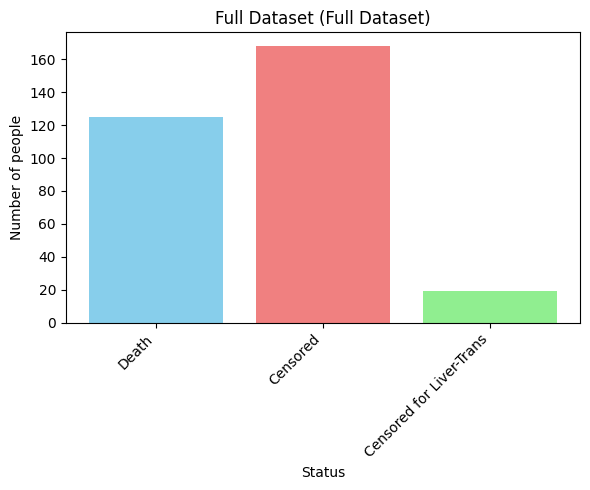

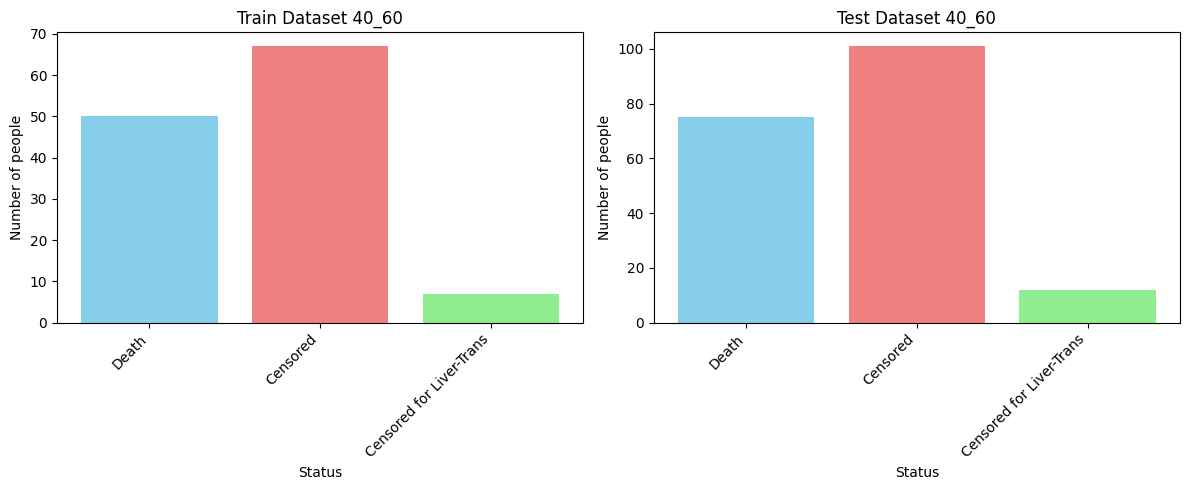

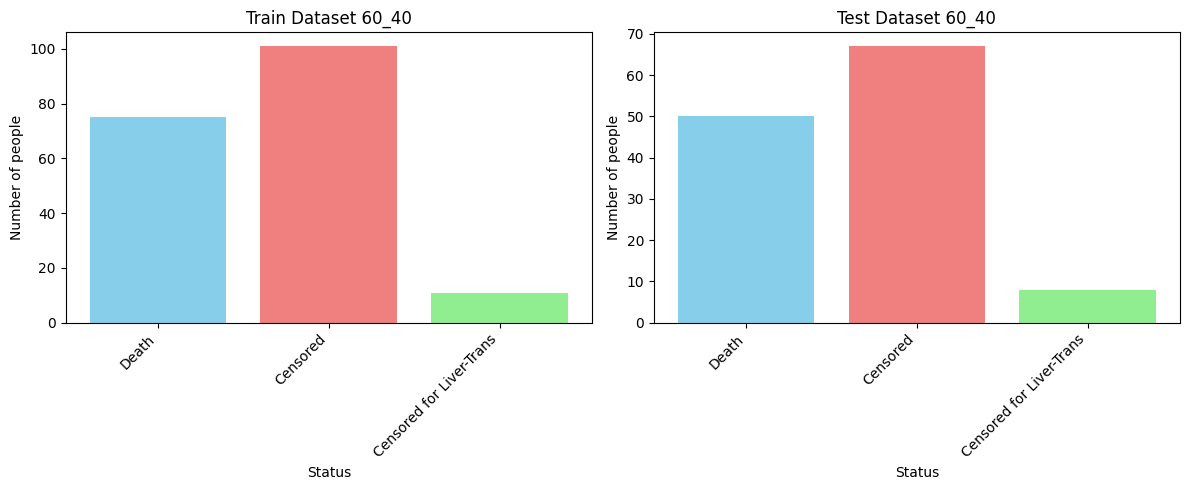

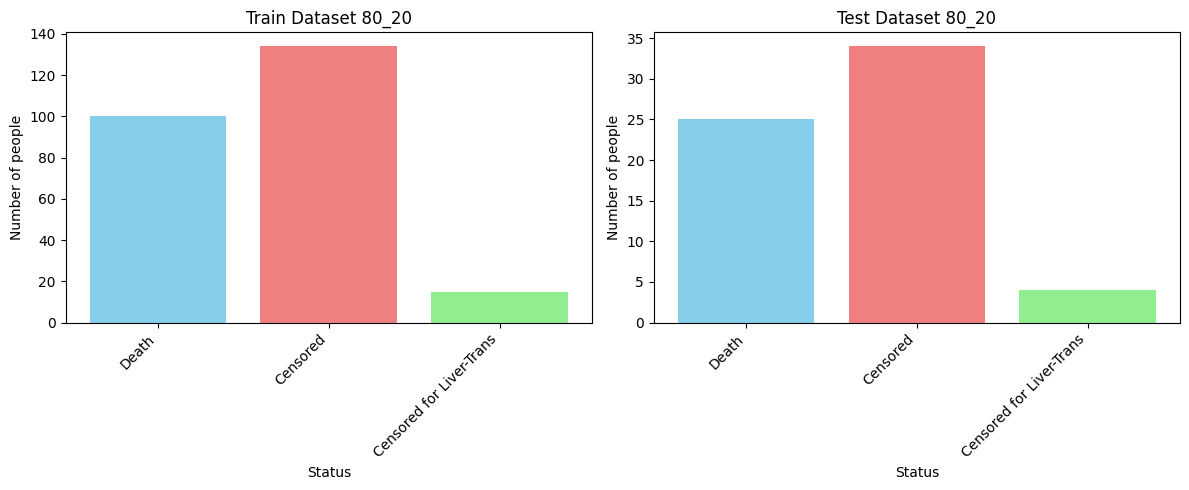

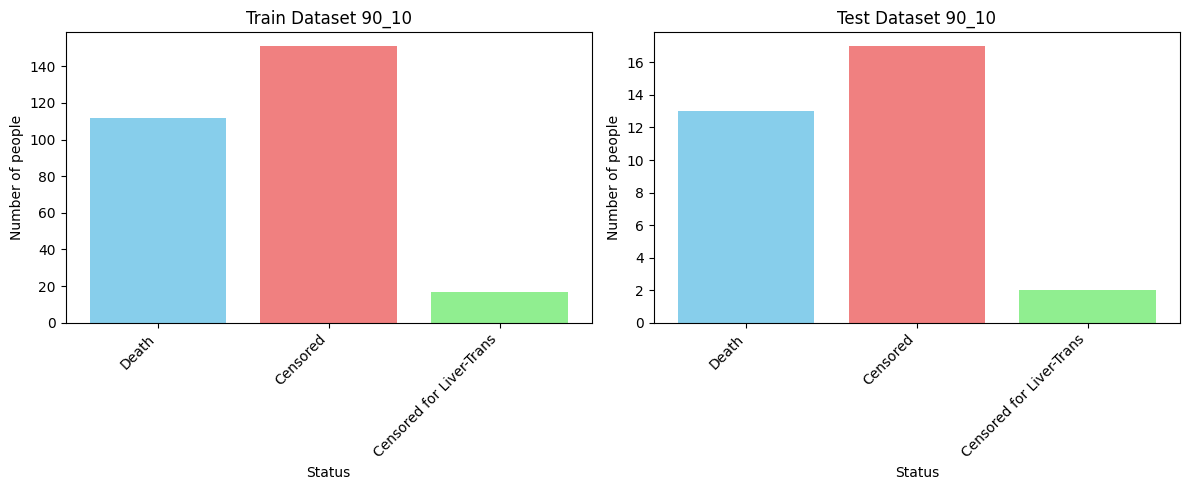

In [21]:
import matplotlib.pyplot as plt

# Mapping numeric values back to their string representations
status_mapping = {0: 'Death', 1: 'Censored', 2: 'Censored for Liver-Trans'}
colors = ['skyblue', 'lightcoral', 'lightgreen']  # Colors for each status

def plot_distribution(y_train, y_test, title_train, title_test):
    if y_train.equals(y_test):
        # If y_train and y_test are identical, plot only one graph
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))

        counts = y_train.value_counts().sort_index()
        labels = counts.index.map(status_mapping)
        values = counts.values

        ax.bar(labels, values, color=[colors[i] for i in counts.index])
        ax.set_title(f"{title_train} (Full Dataset)")
        ax.set_xlabel("Status")
        ax.set_ylabel("Number of people")
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha='right')

    else:
        # Else, plot two side-by-side graphs
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Plot for the training set
        counts_train = y_train.value_counts().sort_index()
        labels_train = counts_train.index.map(status_mapping)
        values_train = counts_train.values
        axes[0].bar(labels_train, values_train, color=[colors[i] for i in counts_train.index])
        axes[0].set_title(title_train)
        axes[0].set_xlabel("Status")
        axes[0].set_ylabel("Number of people")
        axes[0].set_xticks(range(len(labels_train)))
        axes[0].set_xticklabels(labels_train, rotation=45, ha='right')

        # Plot for the test set
        counts_test = y_test.value_counts().sort_index()
        labels_test = counts_test.index.map(status_mapping)
        values_test = counts_test.values
        axes[1].bar(labels_test, values_test, color=[colors[i] for i in counts_test.index])
        axes[1].set_title(title_test)
        axes[1].set_xlabel("Status")
        axes[1].set_ylabel("Number of people")
        axes[1].set_xticks(range(len(labels_test)))
        axes[1].set_xticklabels(labels_test, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Example usage
# Visualize the full dataset (y vs y)
plot_distribution(y, y, "Full Dataset", "Full Dataset")

# Visualize each train/test split
for ratio in split_ratios:
    key = f"{int(ratio * 100 + 0.001)}_{int((1 - ratio + 0.001) * 100)}"
    plot_distribution(
        datasets[f"label_train_{key}"],
        datasets[f"label_test_{key}"],
        f"Train Dataset {key}",
        f"Test Dataset {key}"
    )

In [22]:
from sklearn.tree import DecisionTreeClassifier

# Store the decision trees for each split
decision_trees = {}

# Loop through each train/test split
for ratio in split_ratios:
    # Create the key (example: 40_60, 60_40, etc.)
    key = f"{int(ratio * 100 + 0.001)}_{int((1 - ratio + 0.001) * 100)}"
    
    # Get feature_train and label_train
    X_train = datasets[f"feature_train_{key}"]
    y_train = datasets[f"label_train_{key}"]

    # Create and train the Decision Tree
    clf = DecisionTreeClassifier(criterion="entropy", random_state=42)
    clf.fit(X_train, y_train)
    decision_trees[f"decision_tree_{key}"] = clf


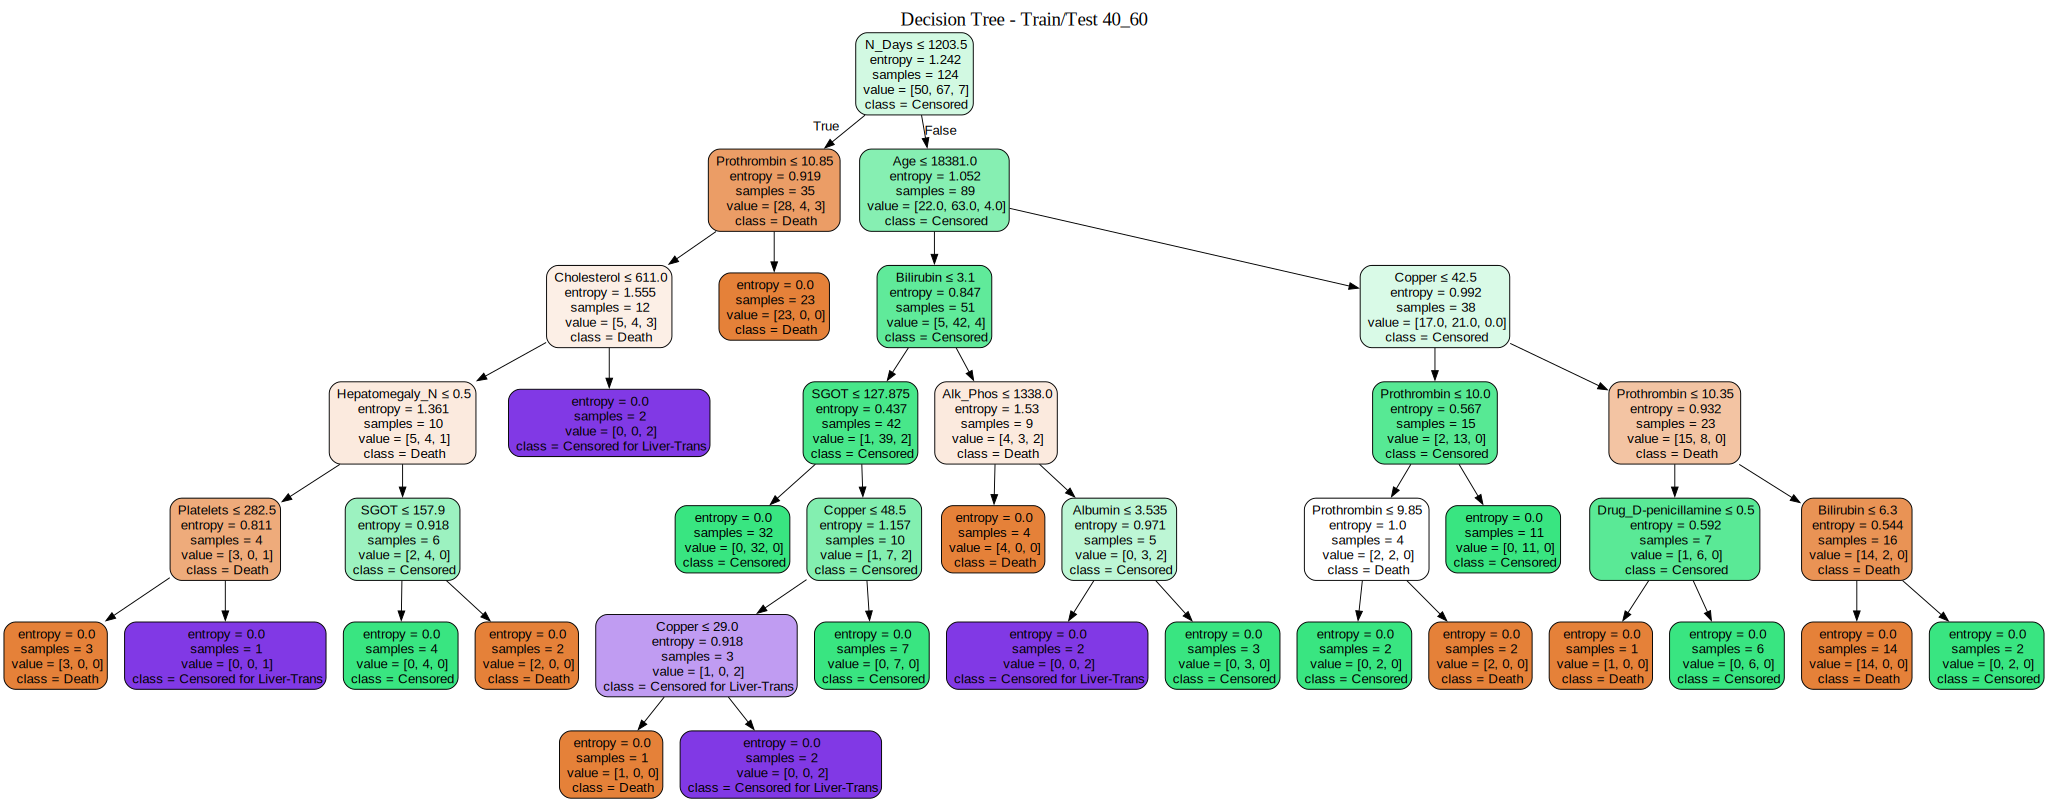

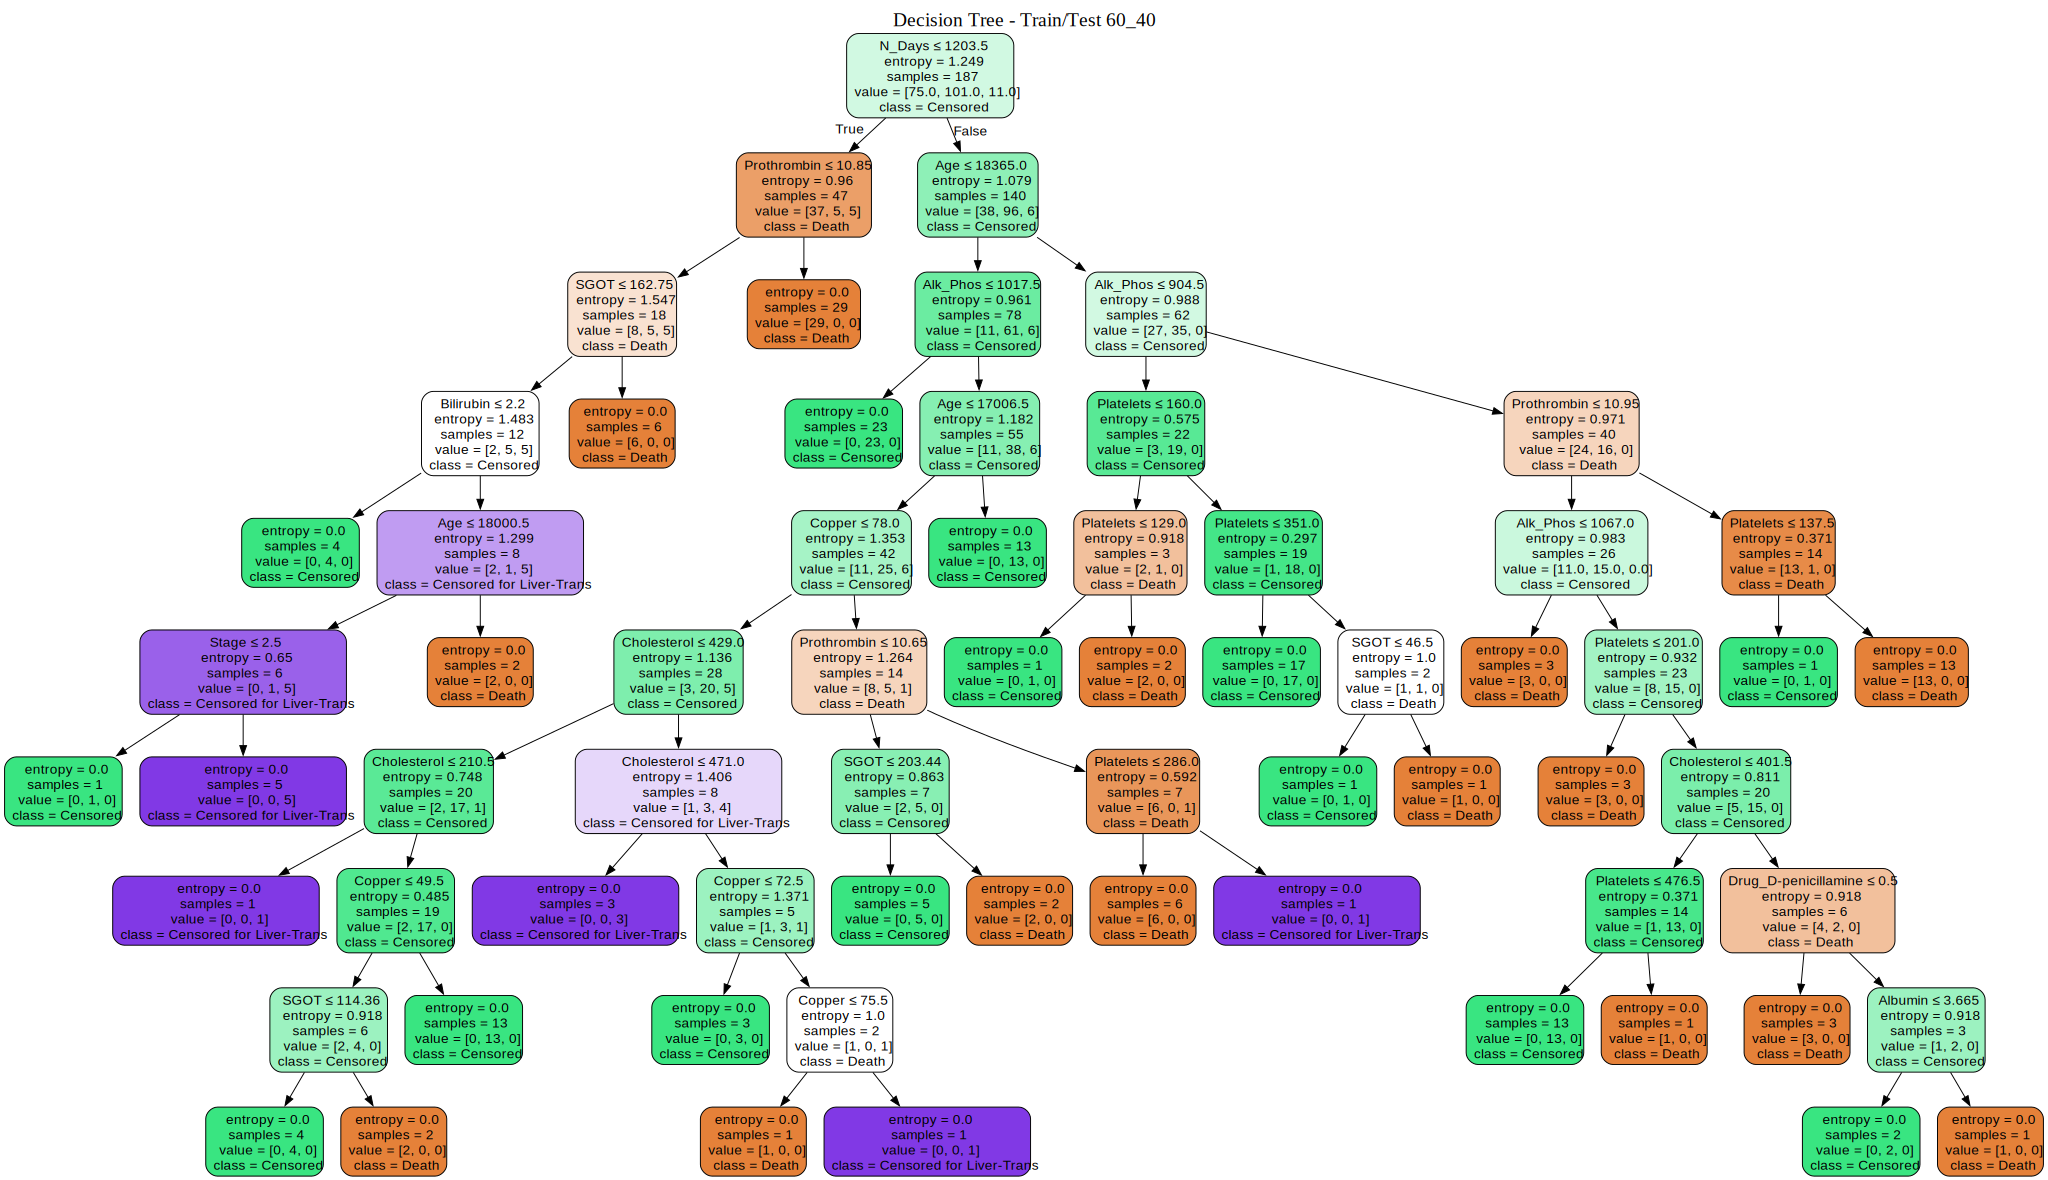

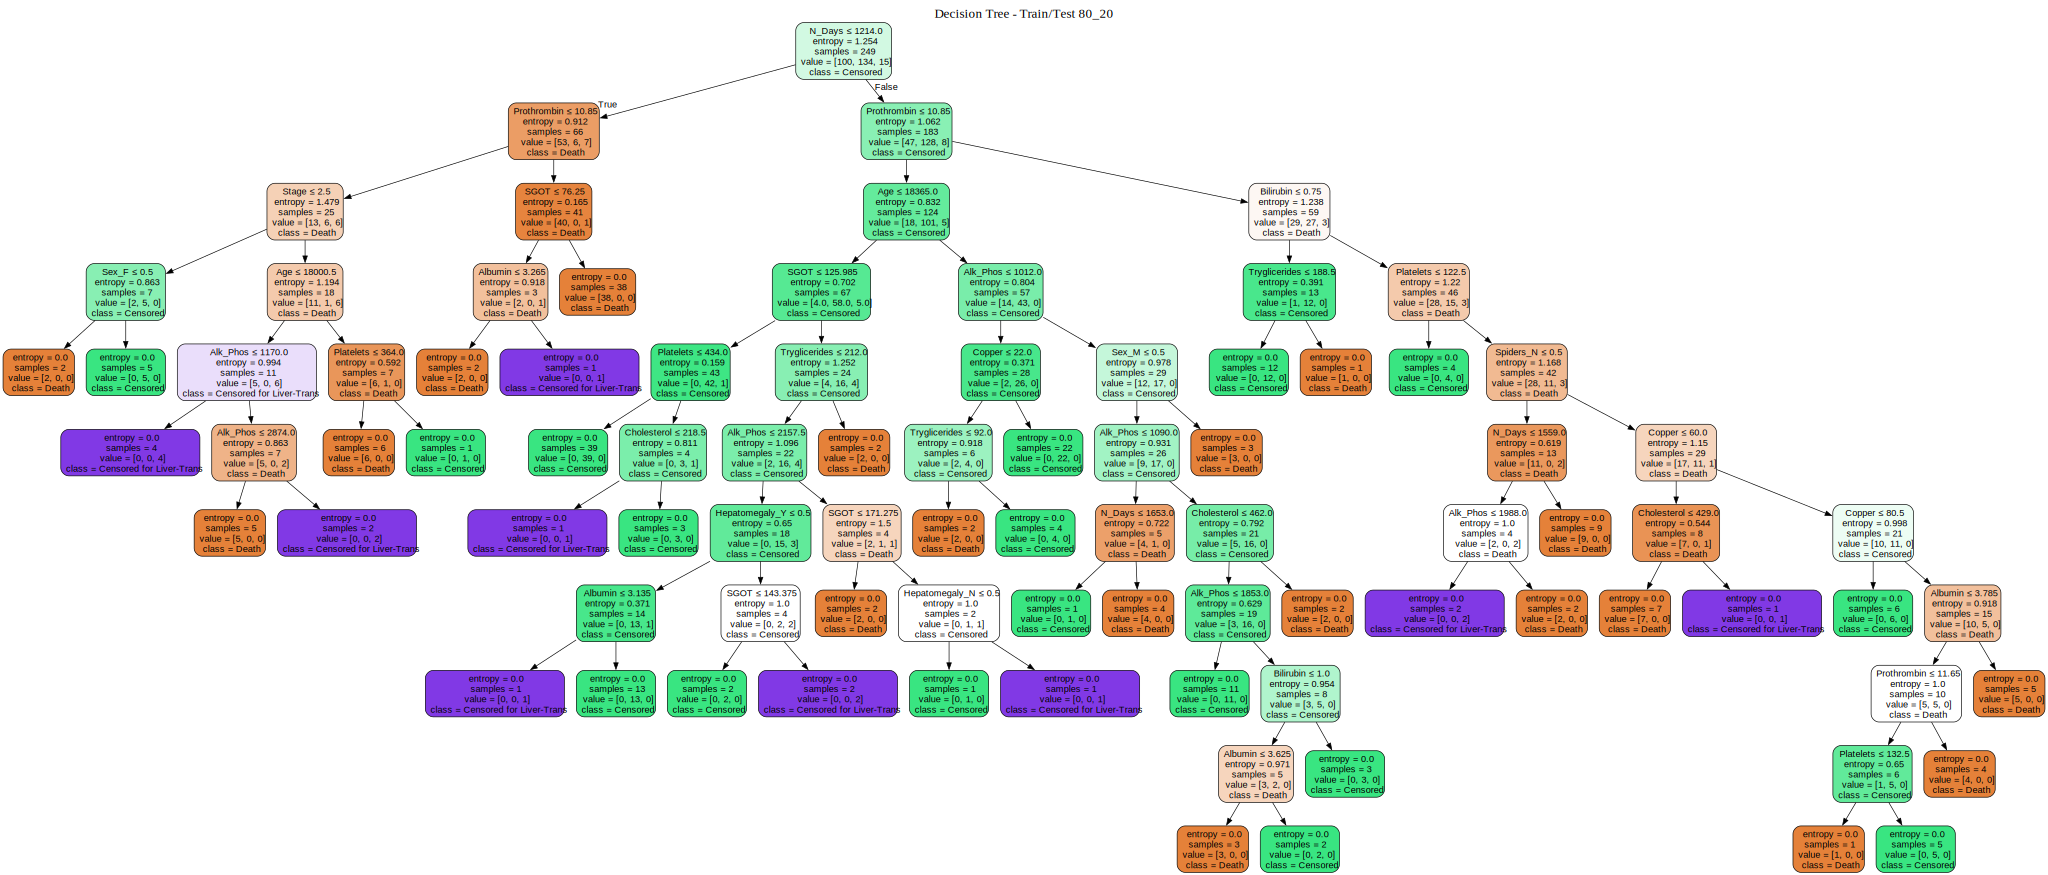

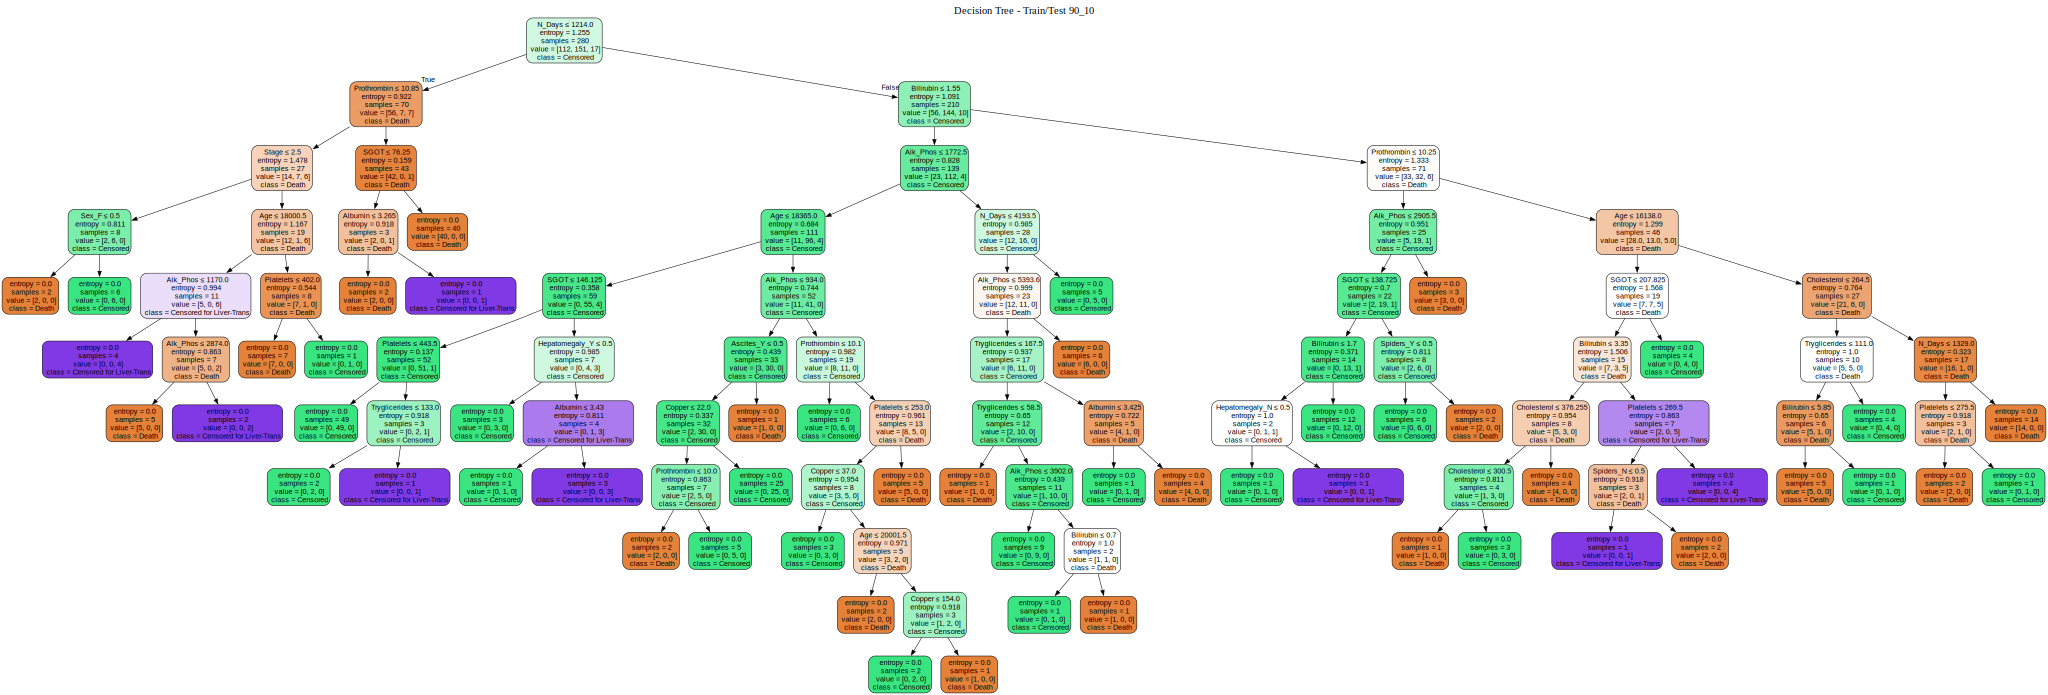

In [23]:
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display

for ratio in split_ratios:
    # Create the key (example: 40_60, 60_40, etc.)
    key = f"{int(ratio * 100 + 0.001)}_{int((1 - ratio + 0.001) * 100)}"
    
    # Get feature_train and label_train
    X_train = datasets[f"feature_train_{key}"]
    clf_train = decision_trees[f"decision_tree_{key}"]
    
    # Export the decision tree to DOT format, adding a name
    dot_data = export_graphviz(
        clf_train,  
        feature_names=X_train.columns, 
        class_names=["Death", "Censored", "Censored for Liver-Trans"], 
        filled=True, 
        rounded=True,
        special_characters=True,
        out_file=None,
    )
    
    dot_data = dot_data.replace(
        'digraph Tree {',
        f'digraph Tree {{\nlabel="Decision Tree - Train/Test {key}";\nlabelloc=top;\nfontsize=20;'
    )    
    # Render the decision tree using Graphviz
    
    graph = graphviz.Source(dot_data)
    display(graph)


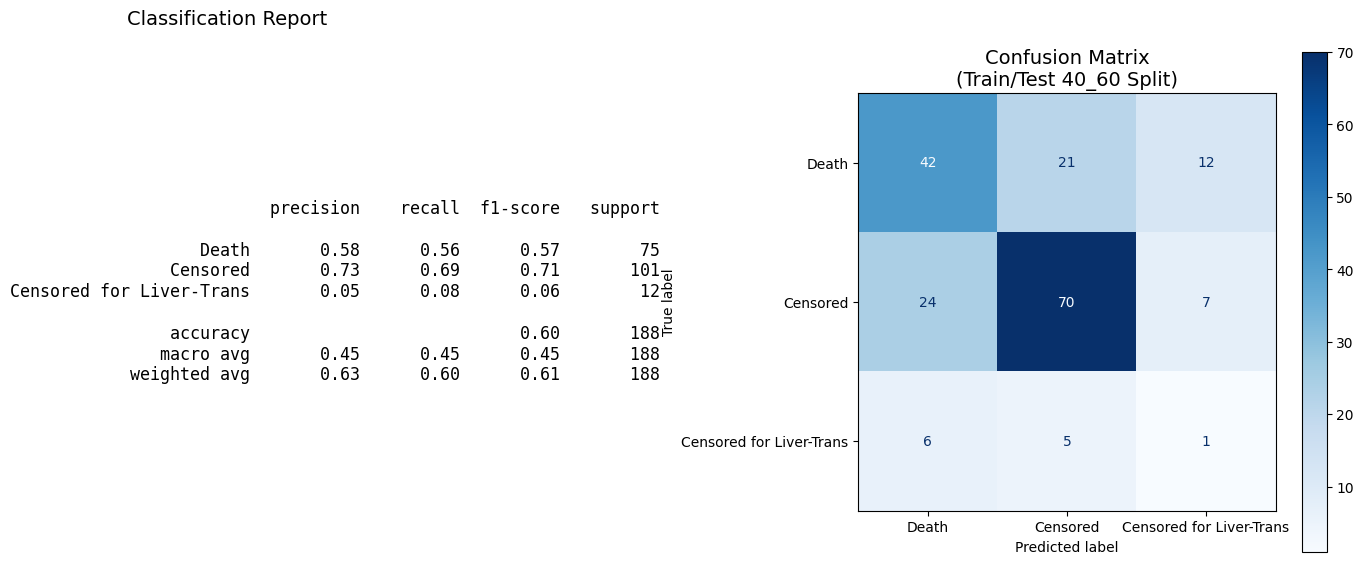

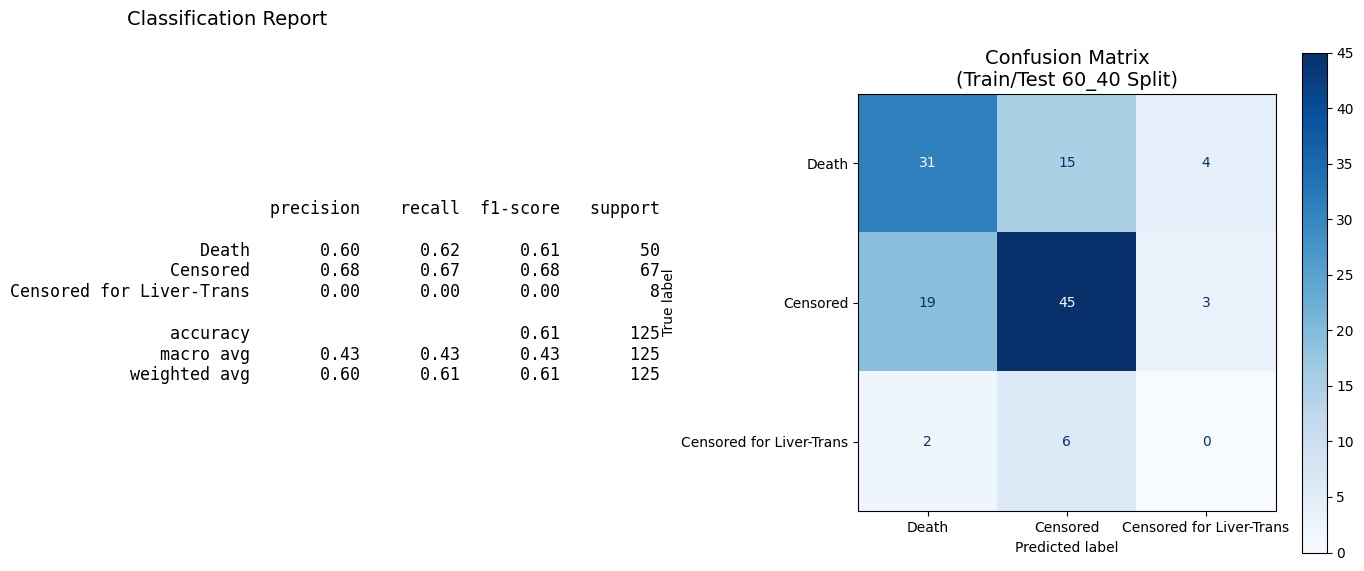

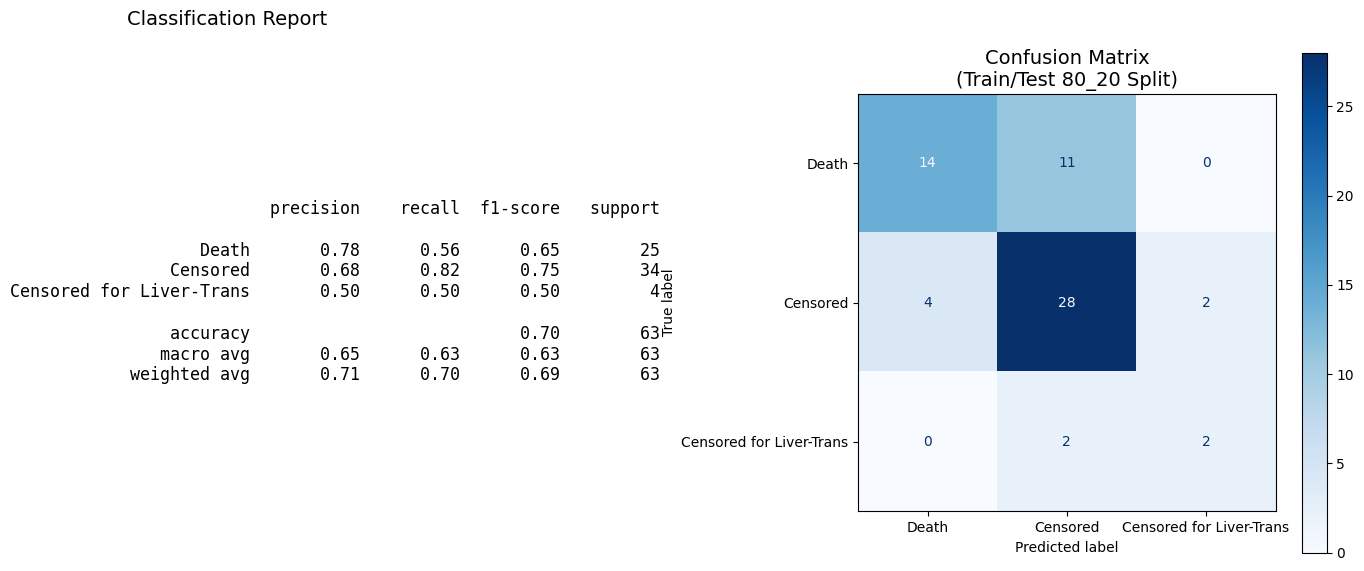

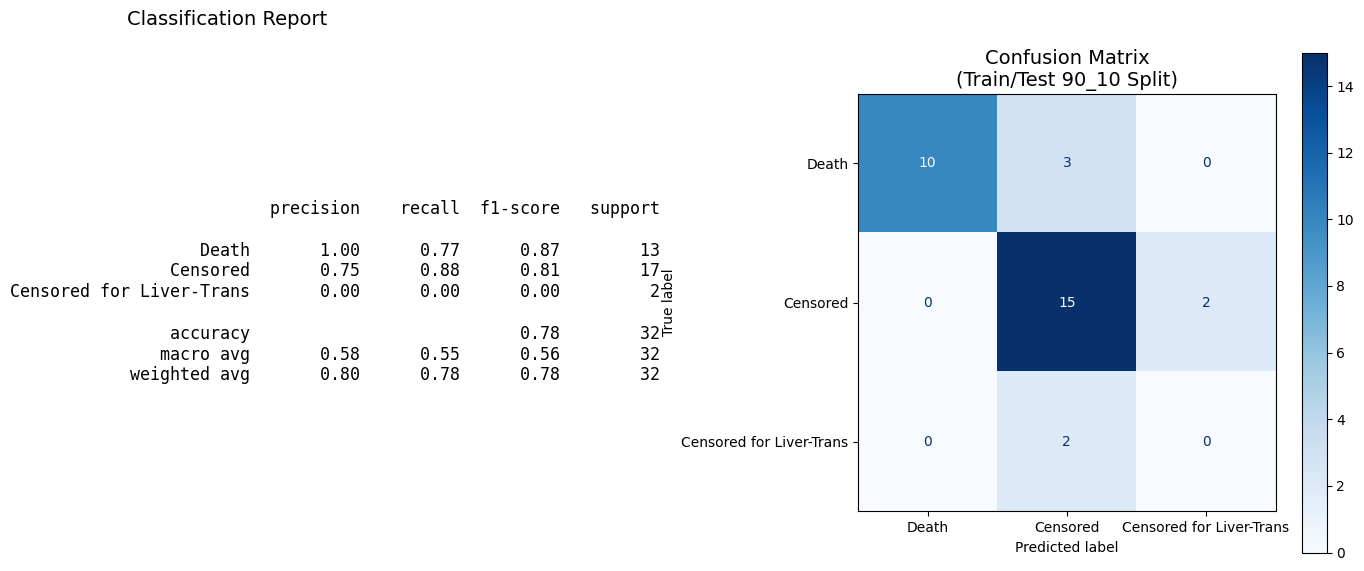

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for ratio in split_ratios:
    # Create key like 80_20
    key = f"{int(ratio * 100 + 0.001)}_{int((1 - ratio + 0.001) * 100)}"
    
    # Load test data
    X_test = datasets[f"feature_test_{key}"]
    y_test = datasets[f"label_test_{key}"]
    
    # Load trained classifier
    clf = decision_trees[f"decision_tree_{key}"]
    
    # Predict
    y_pred = clf.predict(X_test)
    
    # Classification report as text
    report_text = classification_report(y_test, y_pred, target_names=["Death", "Censored", "Censored for Liver-Trans"])
    # print(f"\nClassification Report (Train/Test {key} Split):\n")
    # print(report_text)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot side-by-side: Classification Report (left) and Confusion Matrix (right)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1.2]})
    
    # Plot classification report text on the left
    axes[0].axis('off')  # Turn off the axes
    axes[0].text(0, 0.5, report_text, fontsize=12, ha='left', va='center', wrap=True, family='monospace')
    axes[0].set_title("Classification Report", fontsize=14, pad=20)
    
    # Plot confusion matrix on the right
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Death", "Censored", "Censored for Liver-Trans"])
    disp.plot(cmap='Blues', ax=axes[1], colorbar=True)
    axes[1].set_title(f"Confusion Matrix\n(Train/Test {key} Split)", fontsize=14)
    
    plt.tight_layout()
    plt.show()


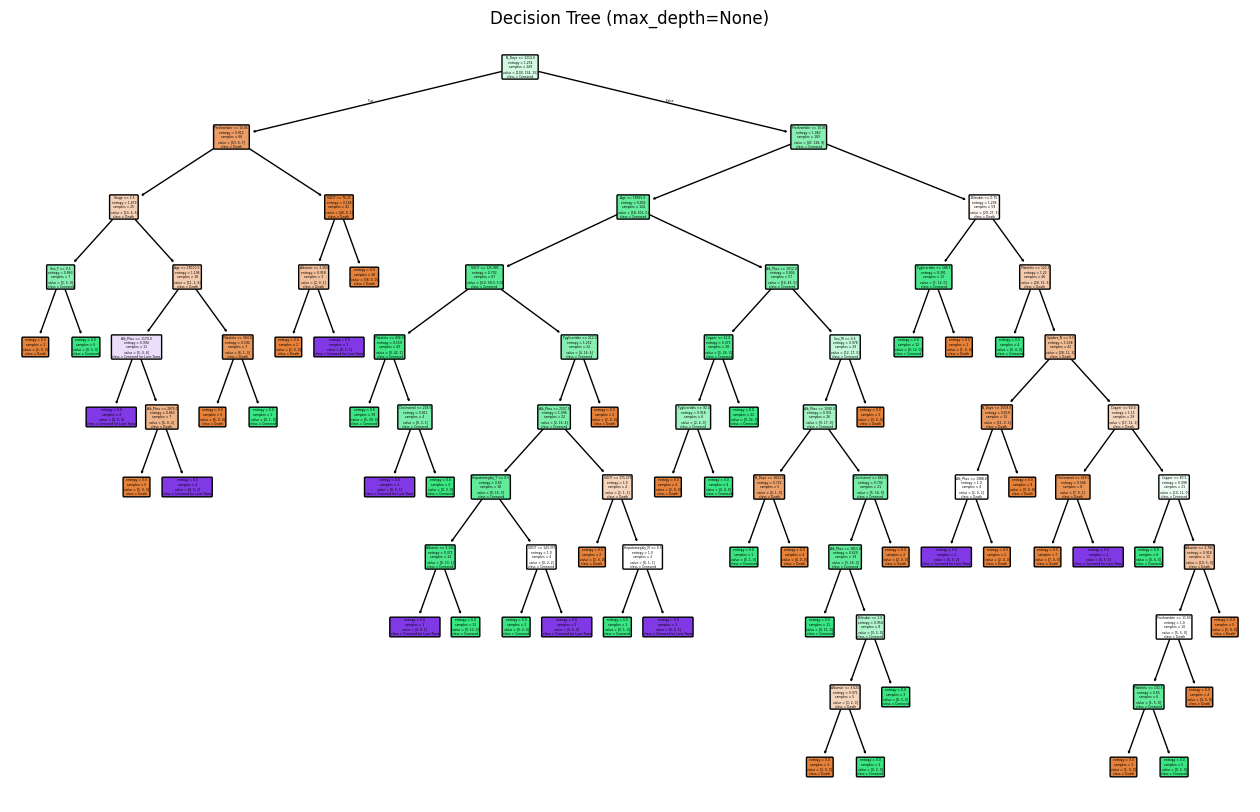

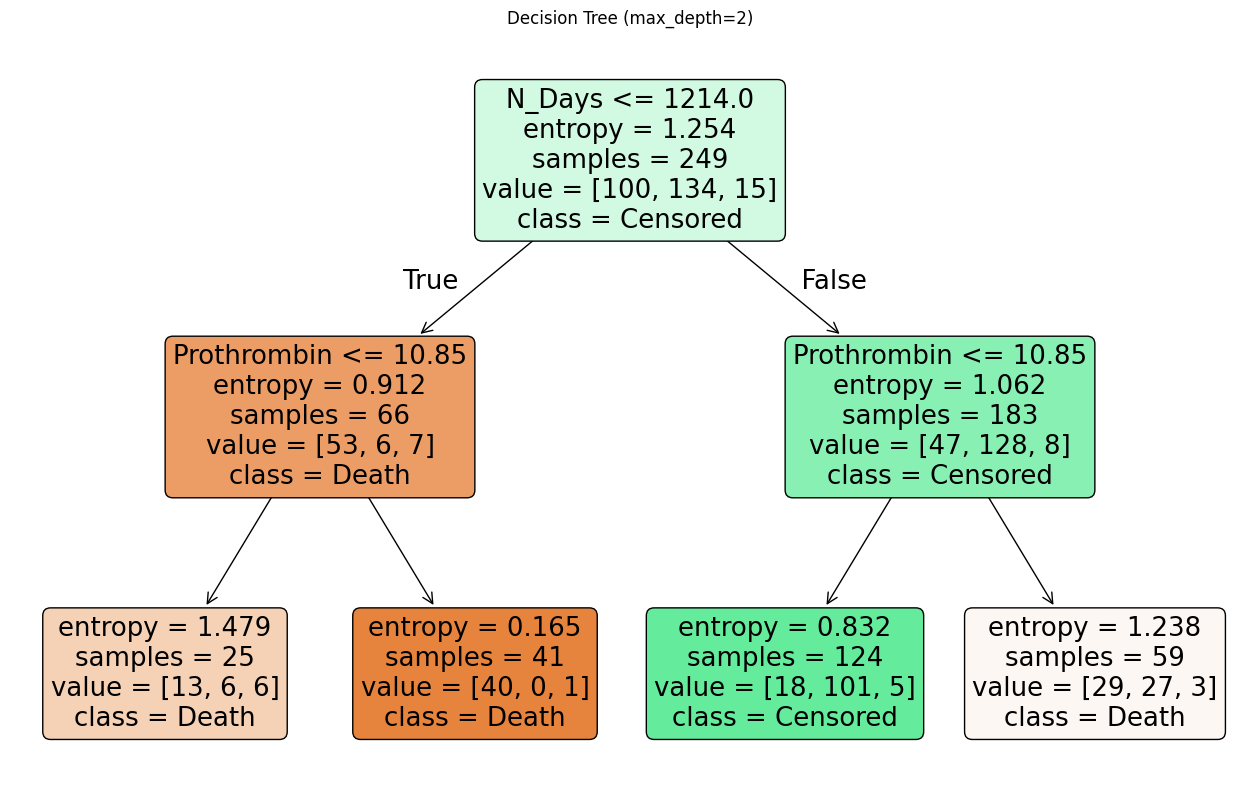

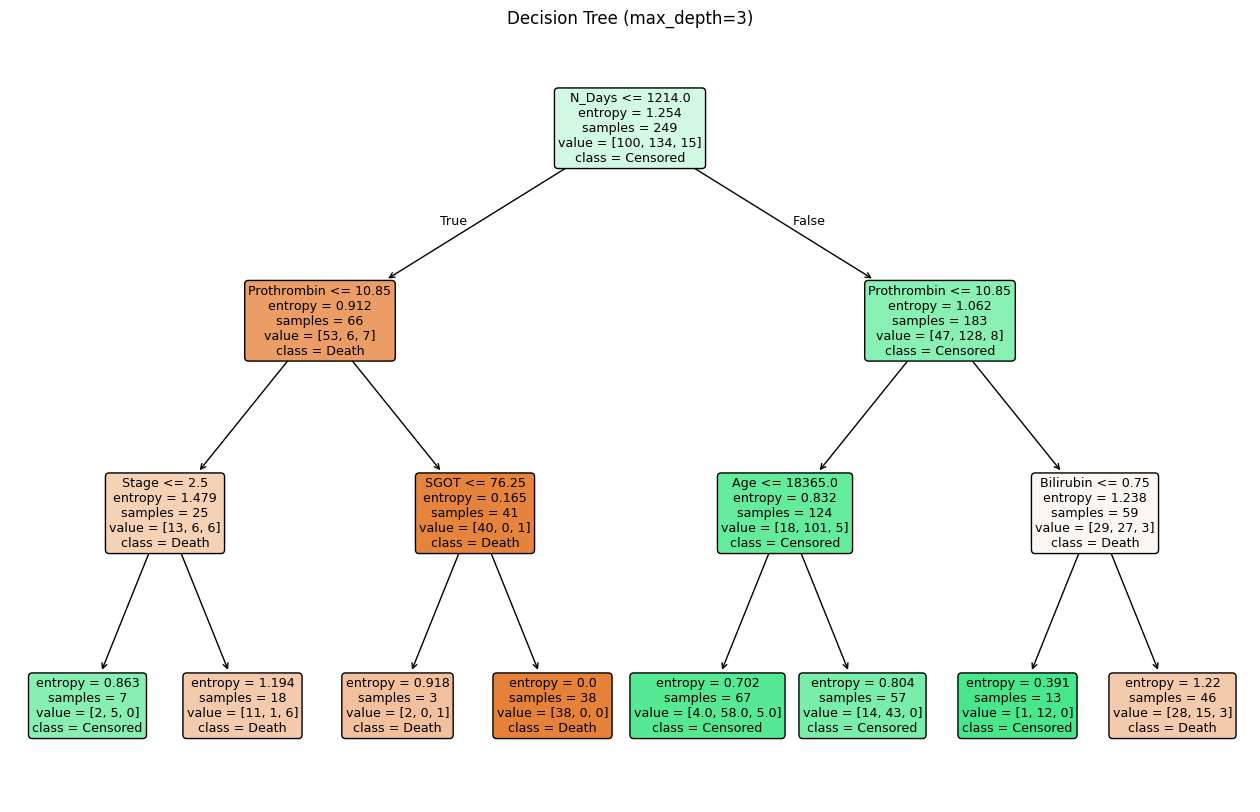

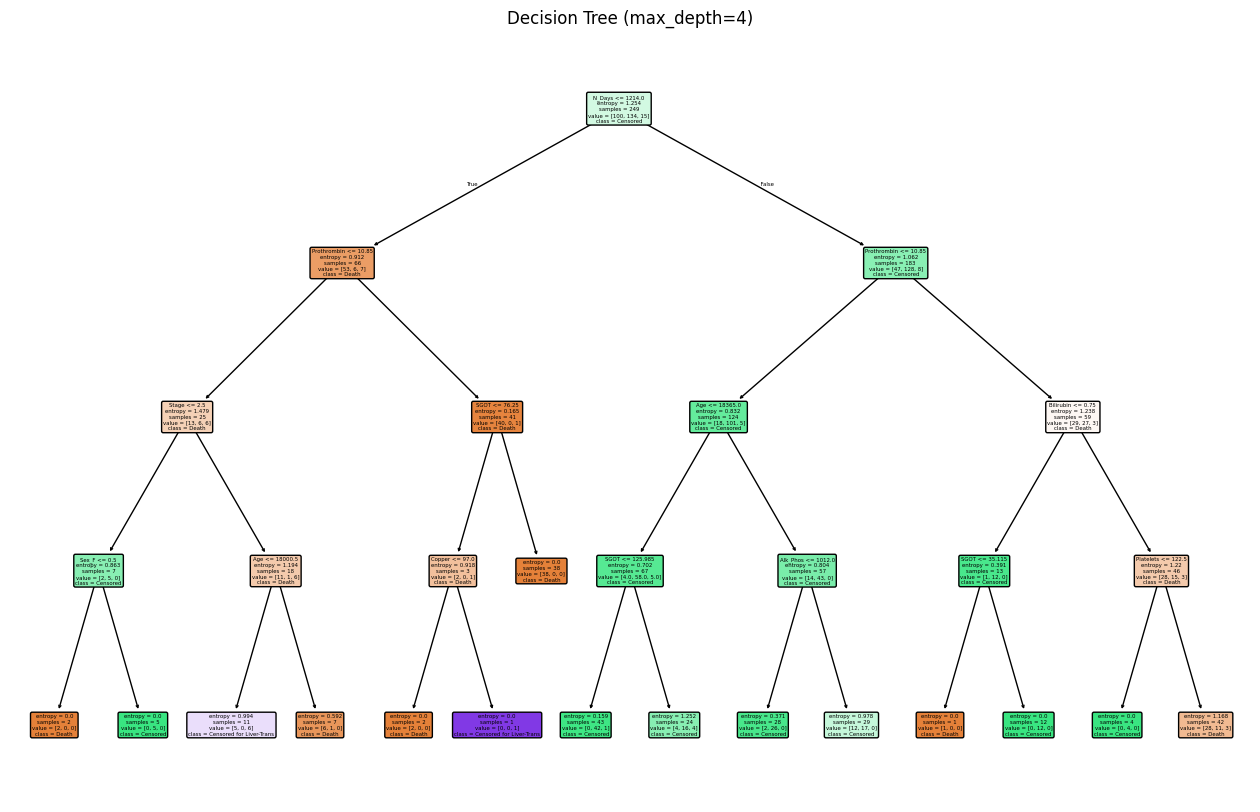

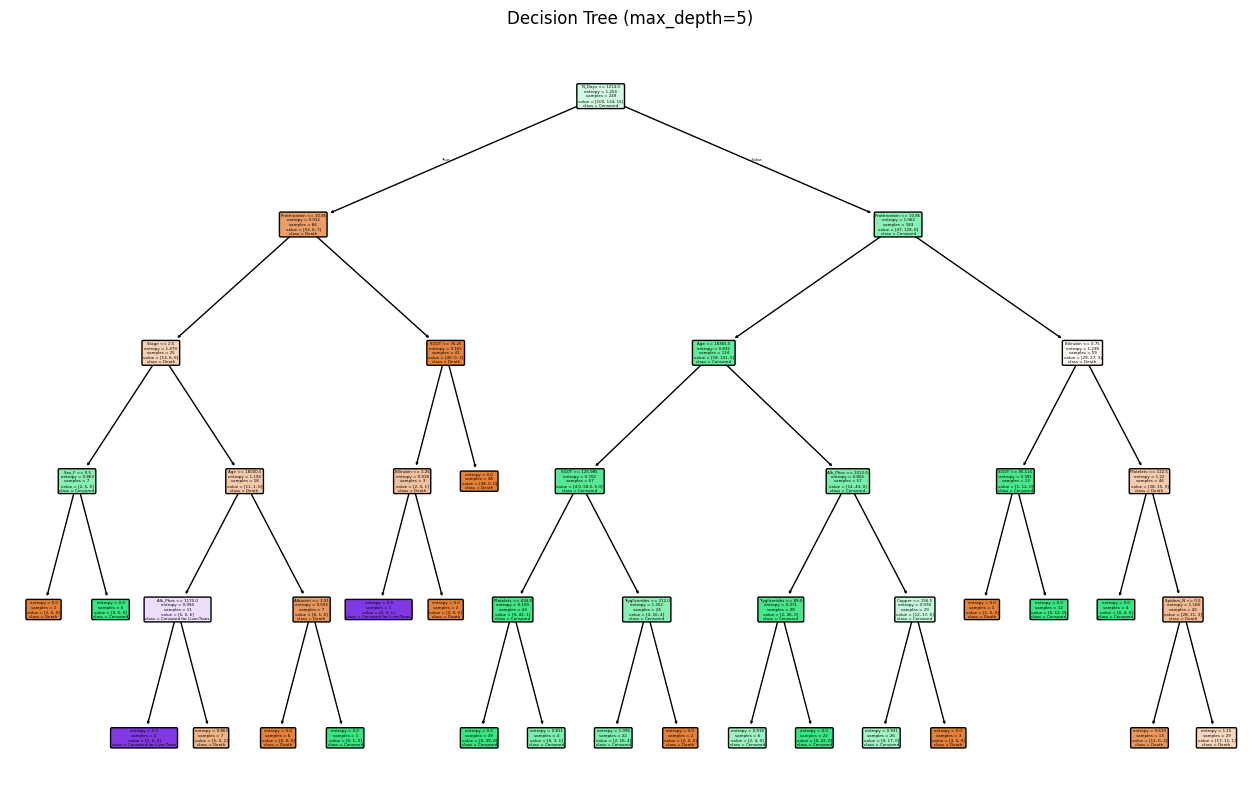

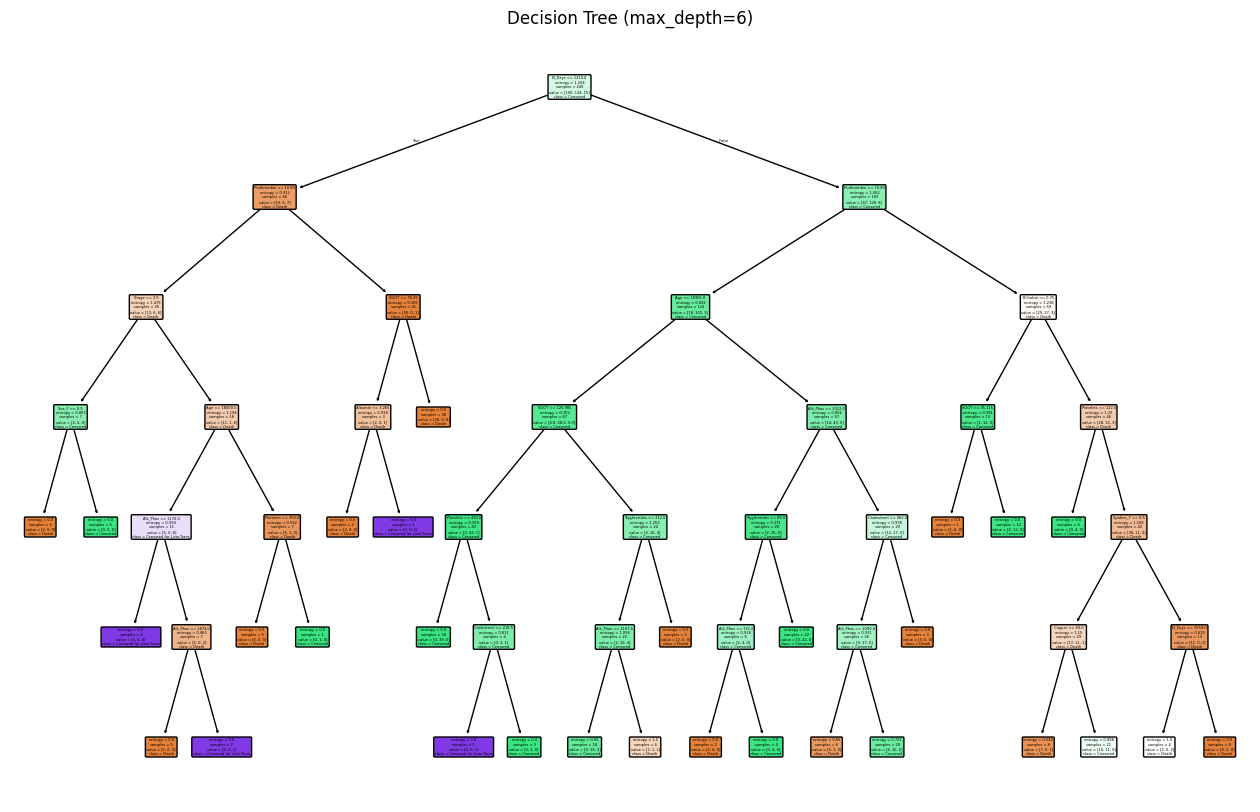

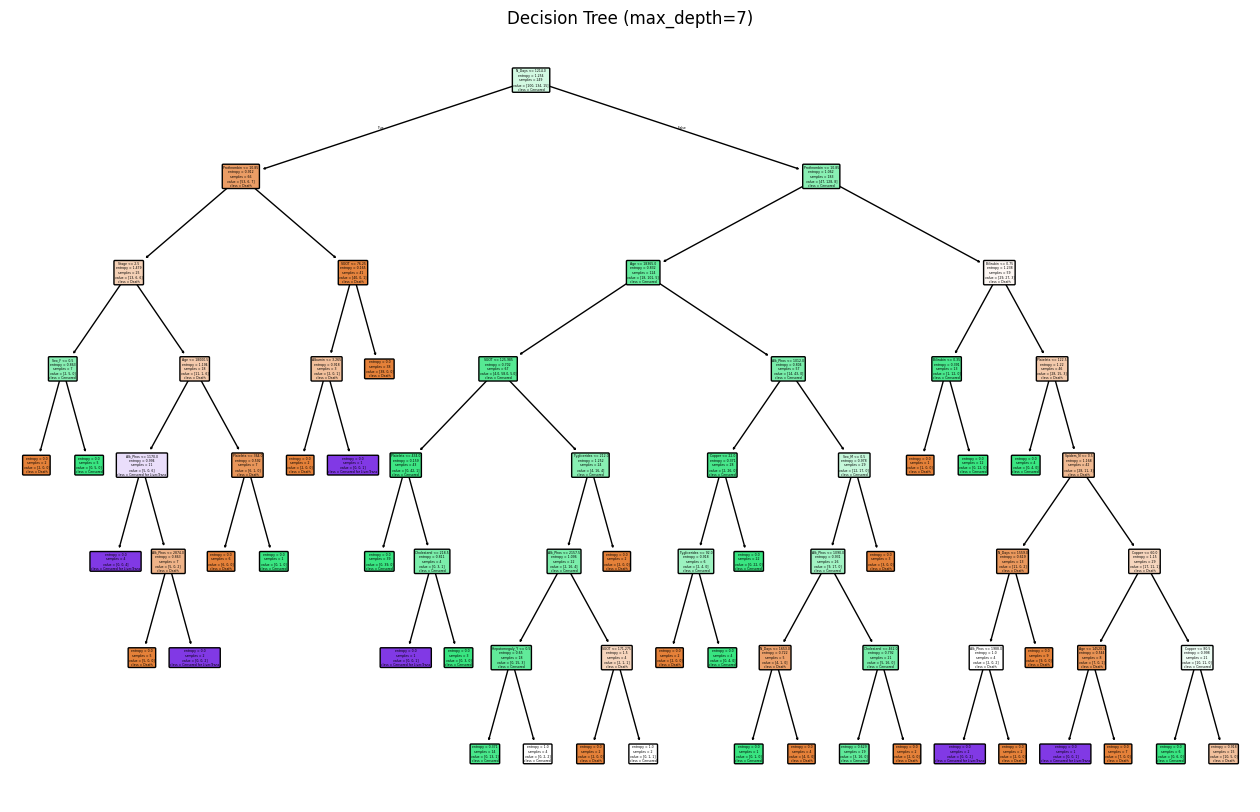


Accuracy Results:
max_depth	Accuracy
None		0.6984
2		0.6190
3		0.6984
4		0.7143
5		0.7302
6		0.6825
7		0.6984


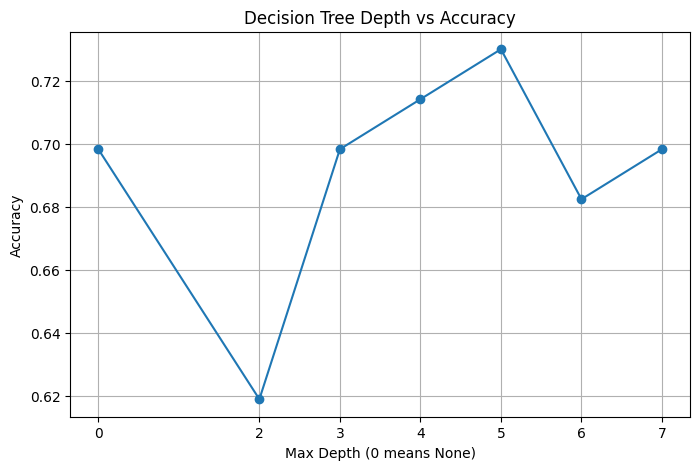

In [25]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Assuming your 80/20 dataset is already prepared:
key = "80_20"
X_train = datasets[f"feature_train_{key}"]
y_train = datasets[f"label_train_{key}"]
X_test = datasets[f"feature_test_{key}"]
y_test = datasets[f"label_test_{key}"]

# Depths to try
depths = [None, 2, 3, 4, 5, 6, 7]

# Store results
accuracy_results = {}

for depth in depths:
    # Train decision tree
    clf = DecisionTreeClassifier(max_depth=depth, criterion="entropy", random_state=42)
    clf.fit(X_train, y_train)
    
    # Predict
    y_pred = clf.predict(X_test)
    
    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    depth_label = "None" if depth is None else str(depth)
    accuracy_results[depth_label] = acc
    
    # Plot tree
    plt.figure(figsize=(16, 10))
    plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["Death", "Censored", "Censored for Liver-Trans"], rounded=True)
    plt.title(f"Decision Tree (max_depth={depth_label})")
    plt.show()

# Show accuracy table
print("\nAccuracy Results:")
print("max_depth\tAccuracy")
for depth_label, acc in accuracy_results.items():
    print(f"{depth_label}\t\t{acc:.4f}")

# Plot depth vs accuracy
plt.figure(figsize=(8, 5))
depth_labels = list(accuracy_results.keys())
acc_values = list(accuracy_results.values())

# For x-axis, handle 'None' separately
x_labels = [0 if d == "None" else int(d) for d in depth_labels]
plt.plot(x_labels, acc_values, marker='o')
plt.xticks(x_labels)
plt.xlabel('Max Depth (0 means None)')
plt.ylabel('Accuracy')
plt.title('Decision Tree Depth vs Accuracy')
plt.grid(True)
plt.show()
